In [40]:
import os
import numpy as np 
import pandas as pd
import sys
from multiprocessing import Pool, cpu_count
from sklearn.metrics import mean_squared_error
from astropy.modeling import models, fitting
sys.path.append('../lib/')
from utils import get_fits_file
from psf_analysis import get_OTF_from_PSF

# F606w's FITS analysis

In [41]:
filepath_data = '../Data/FITS/'
wavelen='F606w'
# Get images as 2-D numpy array from FITS file of F606w
fits_f606, image_f606 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F606w fits file
fits_f606.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   


In [42]:
image = image_f606.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15048535457778456


In [43]:
filepath_results = '../Results/'
file = f'ID_coords_image_{wavelen}.csv'
df = pd.read_csv(filepath_results+file)
df

,ID,Xcor,Ycor
0,7873,4703,542
1,12547,3284,633
2,13066,4497,644
3,23114,4082,780
4,23342,5892,782
...,...,...,...
1177,893600,5870,10241
1178,894495,6753,10257
1179,897539,7124,10323
1180,898640,5807,10352


In [6]:
filepath_results = '../Results/'
file = f'ID_coords_image_{wavelen}.csv'
df = pd.read_csv(filepath_results+file)
df

,ID,Xcor,Ycor
0,7873,4703,542
1,12547,3284,633
2,13066,4497,644
3,23114,4082,780
4,23342,5892,782
...,...,...,...
1177,893600,5870,10241
1178,894495,6753,10257
1179,897539,7124,10323
1180,898640,5807,10352


# Gaussian 2D fitting

In [7]:
def get_star_box(ID: int, IDs: np.ndarray = df.to_numpy(),
                 img: np.ndarray = image, bb: int = 15, norm=True) -> np.array:
    """Get the box with the star's maximum intensity at center.

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.
        bb (int, optional): half side of the squared box.
                            Defaults to 15.

    Returns:
        np.array: star's box.
    """
    xc, yc = IDs[IDs[:,0] == ID, 1:].flatten()
    mat = img.copy() 
    box = mat[yc - bb:yc + bb, xc - bb: xc + bb]
    Ai = np.max(box)
    xi = xc - bb + np.where(box == Ai)[1][0]
    yi = yc - bb + np.where(box == Ai)[0][0]
    
    # check if max intensity is at central pixel
    if [xc, yc] != [xi, yi]:
        box = mat[yi - bb: yi + bb, xi - bb: xi + bb]
        xc, yc = xi, yi
    
    if norm:    
        box /= Ai
    else:
        pass
    
    return box, xc, yc, Ai

In [63]:
def r_squared(y_true, y_pred):
    correlation_matrix = np.corrcoef(y_true, y_pred)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy ** 2

In [81]:
def gauss2d_fitting(ID: int, IDs: np.ndarray = df.to_numpy(),
                    img: np.ndarray = image, bb: int = 15) -> np.array:
    """Compute the Gaussian 2D function of a given star 

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.
        bb (int, optional): half side of the squared box.
                            Defaults to 15.

    Returns:
        np.array: star's ID, initial guess for the fitting parameters,
                  best fit parameters and mse.
    """    
    box, *params = get_star_box(ID)
    xc, yc, Ai = params
    yp, xp = box.shape 
    y, x = np.mgrid[:yp, :xp]
    
    try:
        # Fitting
        fit = fitting.LevMarLSQFitter()   
        fi = models.Gaussian2D(amplitude=1., x_mean=bb, y_mean=bb,
                               x_stddev=1., y_stddev=1., theta=0.)
        f = fit(fi, x, y, box)
        # Best fit parameters
        A = f.amplitude[0]
        x0 = xc - bb + f.x_mean[0]
        y0 = yc - bb + f.y_mean[0]
        sigma_x = f.x_stddev[0]
        sigma_y = f.y_stddev[0]
        theta = f.theta[0]
        # Compute the r squared
        r2 = r_squared(box, f(x, y))
        
        return np.array([ID, Ai, xc, yc, A, x0, y0, sigma_x, sigma_y, theta, r2])
    except:
        return np.array([ID] + [0] * 10)

In [9]:
def get_save_results(wavelen, fit_func):
    func_name = fit_func.__name__
    name = func_name.split('_')[0]
    file = f'fit_results_{wavelen}_{name}.csv'
    if os.path.isfile(filepath_results + file):
        pass
    else:
        if func_name == 'gauss2d_fitting':
            columns = ['ID', 'Ai', 'xi', 'yi', 'A', 'x0','y0',
                       'sigma_x', 'sigma_y', 'theta', 'r2']
        elif func_name == 'gauss1d_fitting':
            columns = ['ID', 'max_int_x', 'max_int_y',
                       'var_x', 'var_y', 'r2_x', 'r2_y']
        else:
            pass   
        p = Pool(cpu_count())
        res = np.asarray(p.map(fit_func, df.ID.to_numpy()))
        p.close()
        results = pd.DataFrame(res, columns=columns)
        results.to_csv(filepath_results + file, index=False)

In [12]:
%%time


get_save_results(wavelen)

TypeError: get_save_results() missing 1 required positional argument: 'fit_func'

# F814w's FITS analysis

In [ ]:
# Get images as 2-D numpy array from FITS file of F814w
wavelen='F814w'
fits_f814, image_f814 = get_fits_file(wavelen=wavelen, fits_path=filepath_data)

# info about F814w fits file
fits_f814.info()

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_F814w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7595   (10065, 10395)   float32   


In [ ]:
image = image_f814.copy()

# Check how many negative values are there
print(image[image < 0].size / image.size)

# setting to 0 all negative values
image[image < 0] = 0

0.15389321980479456


In [ ]:
file = f'ID_coords_image_{wavelen}.csv'
df = pd.read_csv(filepath_results+file)
df

,ID,Xcor,Ycor
0,112180,1826,1596
1,150411,5172,1919
2,159371,6412,2006
3,175660,3590,2174
4,208655,3586,2547
5,214729,1864,2624
6,238668,8398,2856
7,271927,5179,3193
8,281175,1143,3299
9,372885,4819,4542


In [ ]:
%%time


get_save_results(wavelen)

Wall time: 0 ns


# Hubble pupil's PSF results

In [ ]:
filepath = '../Results/Hubble/'
PSF = np.load(filepath + 'Hubble_pupil.npy')
OTF_shift = get_OTF_from_PSF(PSF)

In [ ]:
def star_deconvolution(ID: int, OTF_shift: np.ndarray=OTF_shift) -> np.ndarray:
    """Compute the Gaussian 2D function of a given star.

    Args:
        ID (float): star ID;
        IDs (np.ndarray, optional): ID of all isolated stars on the
                                    image. Defaults to df.to_numpy().
        img (np.ndarray, optional): data from fits file.
                                    Defaults to image.

    Returns:
        np.array: star's ID, initial guess for the fitting parameters,
                  best fit parameters and mse.
    """
    box = get_star_box(ID)
    bb = box.shape[0] // 2
    
    xc, yc = np.where(PSF==PSF.max())
    xc, yc = xc[0], yc[0]
    PSF_cut = PSF[yc-bb:yc+bb, xc-bb:xc+bb]
    box_fft = np.fft.fft2(box)
    
    OTF = np.fft.fft2(PSF_cut)
    box_fft_shift = np.fft.fftshift(box_fft)
    OTF_shift = np.fft.fftshift(OTF)
    
    real_obj_F = box_fft_shift / OTF_shift
    real_obj_shift = np.fft.ifft2(real_obj_F)
    real_obj = np.abs(np.fft.ifftshift(real_obj_shift))
    mse = mean_squared_error(real_obj, box)
    return np.array([ID, mse]) 

In [14]:
from scipy.optimize import curve_fit

def Gaussian1D(x, A, mu, var):
    factor = A / np.sqrt(2. * np.pi * var)
    return factor * np.exp(- 0.5 * (x - mu) ** 2. / var)

In [15]:
def gauss1d_fitting(ID):
    from sklearn.metrics import r2_score
    box, *_ = get_star_box(ID=ID, norm=False)
    xmax, ymax = np.where(box == box.max())
    xmax, ymax = xmax[0], ymax[0]
    
    x_profile = box[ymax, :]
    y_profile = box[:, xmax]
    
    n = box.shape[0]
    x = np.arange(n)
    try:
        popt_x, pcov_x = curve_fit(Gaussian1D, x, x_profile)
        popt_y, pcov_y = curve_fit(Gaussian1D, x, y_profile)
        
        A_x, mu_x, var_x = popt_x
        A_y, mu_y, var_y = popt_y
        
        int_x = Gaussian1D(mu_x, *popt_x)
        int_y = Gaussian1D(mu_y, *popt_y)
        
        x_expected = Gaussian1D(x, *popt_x)
        y_expected = Gaussian1D(x, *popt_y)
        
        r2_x = r2_score(x_profile, x_expected)
        r2_y = r2_score(y_profile, y_expected)
        
        return np.array([ID, int_x, int_y, var_x, var_y, r2_x, r2_y])
    except:
        return np.array([ID] + [np.nan] * 6)

In [38]:
from utils import latex_settings
import matplotlib.pyplot as plt

def gauss1d_plot(ID):
    
    box, *_ = get_star_box(ID=ID, norm=False)

    xmax, ymax = np.where(box == box.max())
    xmax, ymax = xmax[0], ymax[0]


    x_profile = box[ymax, :]
    y_profile = box[:, xmax]

    n = box.shape[0]
    x = np.arange(n)

    fig, axs = latex_settings(1, 2)
    
    popt_x, pcov_x = curve_fit(Gaussian1D, x, x_profile)
    popt_y, pcov_y = curve_fit(Gaussian1D, x, y_profile)
    x_expected = Gaussian1D(x, *popt_x)
    y_expected = Gaussian1D(x, *popt_y)
    
    axs[0].plot(x_profile, 'b')
    axs[0].plot(Gaussian1D(x, *popt_x), '--r')
    axs[1].plot(y_profile, 'b', label='data')
    axs[1].plot(Gaussian1D(x, *popt_y), '--r', label='fit')
    axs[0].set_xlabel('X-axis position [pixels]')
    axs[1].set_xlabel('Y-axis position [pixels]')
    axs[0].set_ylabel('Intensity [ADU]')
    axs[1].legend()

    fig.suptitle('Gaussian fit', fontsize=15)
    
    plt.savefig('Gaussian1d_fit_samples.png', dpi=800, transparent=1)
    
    return x_profile, y_profile, x_expected, y_expected

<ipython-input-14-c888073bbc32>:4: RuntimeWarning: invalid value encountered in sqrt
  factor = A / np.sqrt(2. * np.pi * var)


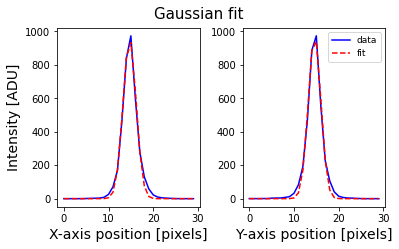

In [39]:
gauss1d_plot(516284)

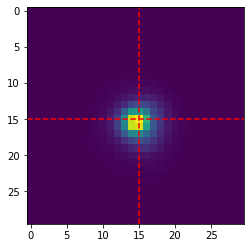

In [ ]:
fig, ax = latex_settings()

ax.imshow(box)
ax.axvline(xmax, ls='--', c='r')
ax.axhline(ymax, ls='--', c='r')

In [41]:
filepath_images_box = '../Images/Box/F606w/'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ID = 877075
image = mpimg.imread(filepath_images_box + f"box_{ID}.png")
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '../Images/Box/F606w/box_877075.png'

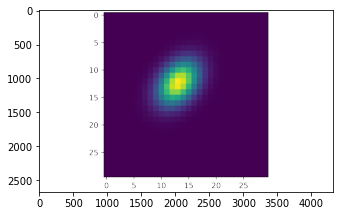

In [42]:
filepath_images_fit = '../Images/Fit/F606w/'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ID = 877075
image = mpimg.imread(filepath_images_fit + f"fit_{ID}.png")
plt.imshow(image)